<a href="https://colab.research.google.com/github/MSY-007/Projet-Neuromorphique-SNN/blob/main/OPTIMISATION-TELECOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install networkx numpy pandas matplotlib folium streamlit streamlit_folium

In [16]:

import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import folium
from IPython.display import HTML

In [17]:
#Données simulées (exemple)

#On peux remplacer ce bloc en important un CSV si tu en as un.

data = pd.DataFrame({
    "nom": ["Centre_Sante","Ecole_Local","Marche_Bouake","Terminal_Bus","Quartier_Rural"],
    "x": [5.330, 5.345, 5.327, 5.319, 5.300],
    "y": [-4.010, -3.995, -4.005, -4.020, -4.030],
    "priorite": [5, 4, 3, 2, 1]
})
data


,nom,x,y,priorite
0,Centre_Sante,5.330,-4.010,5
1,Ecole_Local,5.345,-3.995,4
2,Marche_Bouake,5.327,-4.005,3
3,Terminal_Bus,5.319,-4.020,2
4,Quartier_Rural,5.300,-4.030,1


In [18]:
#Création du graphe pondéré

G = nx.Graph()

for i, row in data.iterrows():

  G.add_node(i, pos=(row["x"], row["y"]), label=row["nom"], priorite=row["priorite"])

for i in G.nodes:
    for j in G.nodes:
        if i != j:
            xi, yi = G.nodes[i]["pos"]
            xj, yj = G.nodes[j]["pos"]
            dist = np.sqrt((xi - xj)**2 + (yi - yj)**2)
            weight = dist / ((G.nodes[i]["priorite"] + G.nodes[j]["priorite"])/2 + 1e-6)
            G.add_edge(i, j, weight=weight)

print("Graphe créé avec", len(G.nodes), "noeuds")

Graphe créé avec 5 noeuds


In [19]:
#Ant Colony Optimization (ACO)


def ant_colony_optimization(G, n_ants=10, n_iter=30, alpha=1.0, beta=2.0, evaporation=0.4, Q=100):
    n_nodes = len(G.nodes())
    pheromone = np.ones((n_nodes, n_nodes))
    best_path, best_cost = None, float('inf')

    for _ in range(n_iter):
        all_paths, all_costs = [], []

        for __ in range(n_ants):
            path = [random.randint(0, n_nodes - 1)]
            while len(path) < n_nodes:
                current = path[-1]
                next_candidates = [c for c in range(n_nodes) if c not in path]
                probs = []

                for c in next_candidates:
                    tau = pheromone[current][c]**alpha
                    eta = (1.0/(G[current][c]["weight"] + 1e-10))**beta
                    probs.append(tau * eta)

                    total = sum(probs)
                if total == 0:
                    break
                probs = [p/total for p in probs]
                chosen = random.choices(next_candidates, weights=probs, k=1)[0]
                path.append(chosen)

            cost = sum(G[path[i]][path[(i+1)%n_nodes]]["weight"] for i in range(len(path)))
            all_paths.append(path)
            all_costs.append(cost)

            if cost < best_cost:
                best_cost = cost
                best_path = path

        pheromone *= (1 - evaporation)
        for p, cost in zip(all_paths, all_costs):
            for i in range(len(p)):
                j = (i+1) % len(p)
                pheromone[p[i]][p[j]] += Q / cost

    return best_path, best_cost

best_path_aco, best_cost_aco = ant_colony_optimization(G)
print("ACO Best Path :", best_path_aco)
print("ACO Best Cost :", best_cost_aco)




ACO Best Path : [3, 2, 1, 0, 4]
ACO Best Cost : 0.04372968805466385


In [20]:
#Ant Colony Optimization (ACO)


def ant_colony_optimization(G, n_ants=10, n_iter=30, alpha=1.0, beta=2.0, evaporation=0.4, Q=100):
    n_nodes = len(G.nodes())
    pheromone = np.ones((n_nodes, n_nodes))
    best_path, best_cost = None, float('inf')

    for _ in range(n_iter):
        all_paths, all_costs = [], []

        for __ in range(n_ants):
            path = [random.randint(0, n_nodes - 1)]
            while len(path) < n_nodes:
                current = path[-1]
                next_candidates = [c for c in range(n_nodes) if c not in path]
                probs = []

                for c in next_candidates:
                    tau = pheromone[current][c]**alpha
                    eta = (1.0/(G[current][c]["weight"] + 1e-10))**beta
                    probs.append(tau * eta)

                    total = sum(probs)
                if total == 0:
                    break
                probs = [p/total for p in probs]
                chosen = random.choices(next_candidates, weights=probs, k=1)[0]
                path.append(chosen)

            cost = sum(G[path[i]][path[(i+1)%n_nodes]]["weight"] for i in range(len(path))) # Consider it as a cycle
            all_paths.append(path)
            all_costs.append(cost)

            if cost < best_cost:
                best_cost = cost
                best_path = path

        pheromone *= (1 - evaporation)
        for p, cost in zip(all_paths, all_costs):
            for i in range(len(p)):
                j = (i+1) % len(p)
                pheromone[p[i]][p[j]] += Q / cost

    return best_path, best_cost

best_path_aco, best_cost_aco = ant_colony_optimization(G)
print("ACO Best Path :", best_path_aco)
print("ACO Best Cost :", best_cost_aco)


ACO Best Path : [4, 0, 2, 1, 3]
ACO Best Cost : 0.04569650608046844


In [21]:
#Genetic Algorithm (GA)

def genetic_algorithm(G, pop_size=50, n_gen=100, elite=5, mutation_rate=0.1):
    nodes = list(G.nodes())
    n_nodes = len(nodes)

    def random_solution():
        sol = nodes[:]
        random.shuffle(sol)
        return sol

    def fitness(sol):
        return sum(G[sol[i]][sol[(i+1)%n_nodes]]["weight"] for i in range(n_nodes))

    def crossover(p1,p2):
        cut = random.randint(1, n_nodes-2)
        child = p1[:cut] + [x for x in p2 if x not in p1[:cut]]
        return child

    def mutate(sol):
        i,j = random.sample(range(n_nodes),2)
        sol[i],sol[j]=sol[j],sol[i]
        return sol

    population=[random_solution() for _ in range(pop_size)]
    for _ in range(n_gen):
        population.sort(key=fitness)
        new_pop=population[:elite]
        while len(new_pop)<pop_size:
            p1,p2=random.sample(population[:20],2)
            child=crossover(p1,p2)
            if random.random()<mutation_rate:
                child=mutate(child)
            new_pop.append(child)
        population=new_pop

    best = min(population, key=fitness)
    return best, fitness(best)

best_path_ga, best_cost_ga = genetic_algorithm(G)
print("GA Best Path :", best_path_ga)
print("GA Best Cost :", best_cost_ga)


GA Best Path : [1, 0, 4, 3, 2]
GA Best Cost : 0.04372968805466385


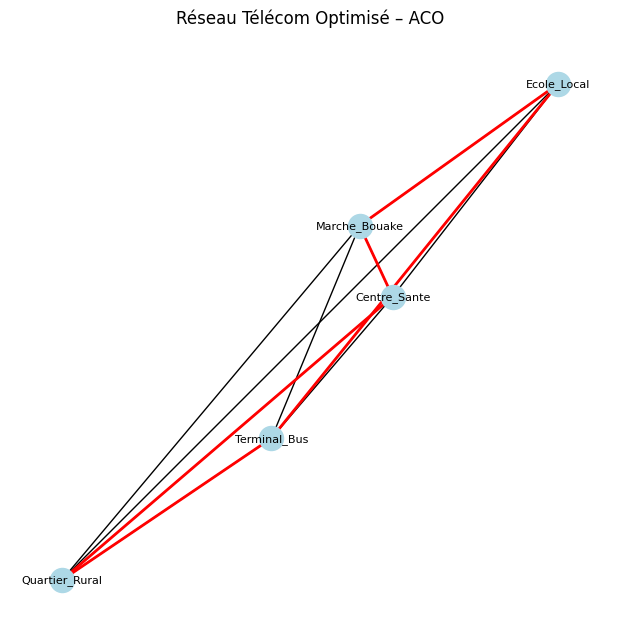

In [22]:
#Visualisation (Matplotlib)*


pos = nx.get_node_attributes(G, 'pos')
labels = {i:data.iloc[i]['nom'] for i in G.nodes}

fig = plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=False, node_size=300, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels, font_size=8)

#tracer chemin ACO

edges_aco = [(best_path_aco[i], best_path_aco[(i+1)%len(best_path_aco)]) for i in range(len(best_path_aco))]
nx.draw_networkx_edges(G, pos, edgelist=edges_aco, edge_color='red', width=2)
plt.title("Réseau Télécom Optimisé – ACO")
plt.show()

In [23]:
#Carte Interactive (Folium)*


lat_mean = data["y"].mean()
lon_mean = data["x"].mean()

m = folium.Map(location=[lat_mean, lon_mean], zoom_start=12)

for _,r in data.iterrows():
    folium.CircleMarker(
        location=[r["y"], r["x"]],
        radius=5 + r["priorite"],
        popup=r["nom"],
        color="blue",
        fill=True
    ).add_to(m)

m
